<a target="_blank" href="https://colab.research.google.com/drive/1142VbFt8kLRz7amDi9UQt5LaJvIcTaZt?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Open-Source Implementation of IEEE P2427 Defect Coverage Standard

```
Submission to IEEE SSCS Open-Source Ecosystem “Code-a-Chip” Travel Grant Awards at ISSCC'25
SPDX-License-Identifier: GPL-3.0-only
```


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Timothy Jabez Newman (lead) <br /> Email ID: contact@timothynewman.co.uk|EnSilica|No|No|
|Feng Shen Foo <br /> Email ID: limited_fion@live.com|Independent|No|No|
|Ashcharya Kela |Independent|No|No|
|Weizheng Wang <br /> Email ID: weizheng.w2020@gmail.com |Independent|No|No|

## Introduction

Over the past decades, the complexity of analog integrated circuits (IC) has increased exponentially. In order to ensure reliable and correct functionality of these ICs, functional tests are required to detect defects that occur in manufacturing. The IEEE P2427 draft standard sets out a defect coverage accounting method based on simulation models for defects observed within Integrated Circuits (IC) [1].

Within this standard, defects are defined as an unintended physical change in a circuit element or connection between circuit elements that is not within fabrication specifications for the circuit element or connection. A defect can cause a significant change in the intended function of the circuit resulting in a fault.

This Jupyter notebook details a prototype implementation of the [IEEE P2427 Draft Standard for Analog Defect Modeling and Coverage](https://standards.ieee.org/ieee/2427/7233/) using open source tools and the open source [Skywater 130A PDK](https://github.com/google/skywater-pdk).

Given a circuit description and a set of tests, this standard defines how to enumerate the universe of defects, determine which defects are detected by the tests, and report the coverage results [1]. This allows designing more effective tests while eliminating redundant tests.

A brief summary of the process is explained:

1. Test circuit is created and netlisted.
2.   Devices and nodes in the netlist are parsed to define the defect universe.
3.   Defects are added into the netlist one at a time throughout the defect universe to create variants of the netlist. Defects are modelled as large parameter changes, shorts or opens.
4.   The netlist is simulated and performance parameters (e.g. gain magnitude or bandwidth) are measured. If the performance parameters fall outside of the expected range, they are classified as failures.
5. Defect coverage is determined based on the percentage of defects detected by the tests and results are then presented.

References:

[1] Anthony Coyette Et Al, "IEEE Draft Standard for Analog Defect Modeling and Coverage", *IEEE Computer Society*, Available: https://standards.ieee.org/ieee/2427/7233/

[2] SkyWater PDK Authors, "SkyWater Open Source PDK", Available: https://github.com/google/skywater-pdk

[3] S. Azam, N. Dall’Ora, E. Fraccaroli, R. Gillon and F. Fummi, "Analog Defect Injection and Fault Simulation Techniques: A Systematic Literature Review," in IEEE Transactions on Computer-Aided Design of Integrated Circuits and Systems, vol. 43, no. 1, pp. 16-29, Jan. 2024, doi: 10.1109/TCAD.2023.3298698.

[4] Saikiran, M., Sekyere, M., Ganji, M. et al. "Low-cost defect simulation framework for analog and mixed signal (AMS) circuits with enhanced time-efficiency". Analog Integrated Circuit and Signal Processing, Volume 117, Pg 73–94 (2023). https://doi.org/10.1007/s10470-023-02167-7

This Jupyter Notebook can be accessed at: https://colab.research.google.com/drive/1142VbFt8kLRz7amDi9UQt5LaJvIcTaZt?usp=sharing

## Setting up of Open Source Tools

NGspice and Skywater 130A PDK are installed using micromamba.

This is largely based on the example at https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/FAQ.md

In [1]:
# Import modules
import os
import pathlib
import sys
import re
import pandas as pd

In [ ]:
!pip install matplotlib pandas pyinstaller
!apt-get install -y ruby-full time build-essential
!apt install -f libqt4-designer libqt4-xml libqt4-sql libqt4-network libqtcore4 libqtgui4
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        xschem \
                        #magic \
                        #netgen \
                        #openroad \
                        #yosys
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click svgutils ngspice
%env PDK=sky130A

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 10.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
The following additional packages will be installed:
  fonts-lato libgmp-dev libgmpxx4ldbl libruby3.0 rake ri ruby ruby-dev ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 ruby3.0-dev ruby3.0-doc rubygems-integration
Suggested packages:
  gmp-doc libgmp10-doc libmpfr-dev bundler
The following NEW packages will be installed:
  fonts-lato libgmp-dev libgmpxx4ldbl libruby3.0 rake ri ruby ruby-dev ruby-full ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 ruby3.0-dev ruby3.0-doc rubygems-integration time
0 upgraded, 18 newly installed, 0 to remove and 20 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 58.2 MB of additional

To implement parameter defects, a modified version of the pdk transistor was created. The next cell downloads the modified the Lib.tech folder and replaces the original folder with the updated version.

In [ ]:
# Download modified Lib.tech folder from github
modified_libs_tech_folders_url = f"https://github.com/TimothyJNewman/open-source-chip-design-v1/raw/refs/heads/main/Modified_PDK/modified_libs_tech_folders.tar.gz"
!wget {modified_libs_tech_folders_url} -O modified_libs_tech_folders.tar.gz
!tar -xzvf modified_libs_tech_folders.tar.gz
!rm -rf /content/conda-env/share/pdk/sky130A/libs.tech/combined/
!rm -rf /content/conda-env/share/pdk/sky130A/libs.tech/xschem/
!cp combined/ /content/conda-env/share/pdk/sky130A/libs.tech/combined/ -r
!cp xschem/ /content/conda-env/share/pdk/sky130A/libs.tech/xschem/ -r


## Example SPICE Netlist

In this demonstration, a testbench is created to test a 5 transistor Operational Amplifier (OpAmp).

The schematic was captured with Xschem and a netlist was generated. Transient and AC simulations and calculations of performance parameters were included in the NGspice directive.



**Schematic of OpAmp:**


Transistors M5 and M6 form a current mirror for biasing the long-tail pair.

Transistors M3 and M4 form the differential pair.

Transistors M1 and M2 form an active load that converts the differential pair small signal currents to voltages and performs a differential to single-ended conversion.

In the disabled state, transistors M8 and M11 are tie-down and tie-up transistors for the current mirror and active load. Similarly, in the disabled state transistor M7 breaks the biasing of the current mirror gate.

Transistors M9 and M10 form an inverter for the enable tie-down.

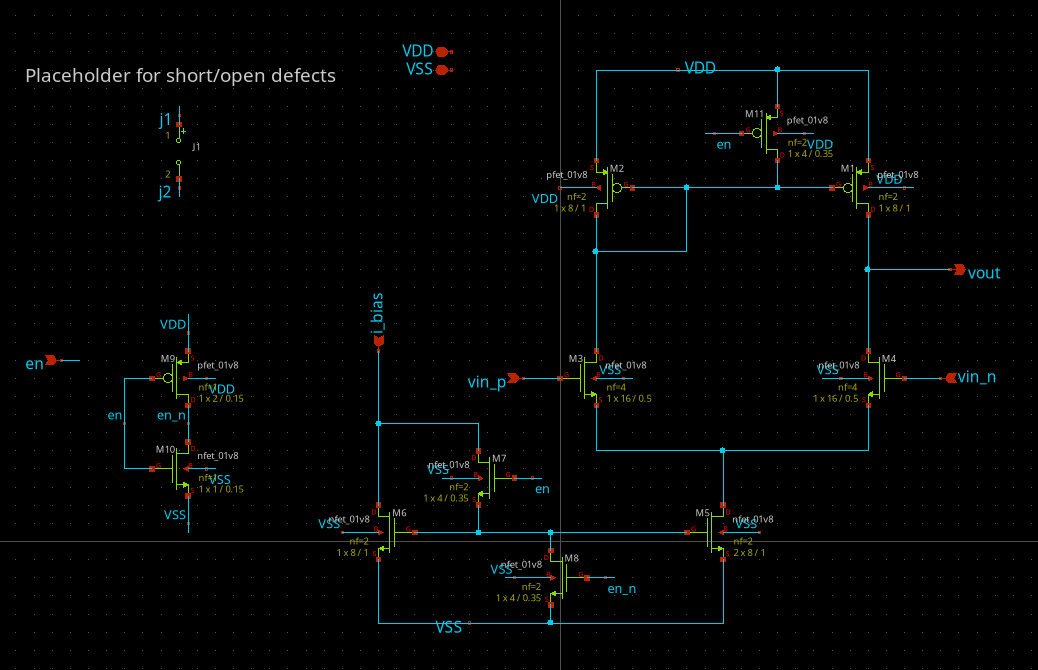

**Test bench for testing the OpAmp circuit:**

The OpAmp circuit is powered with a 1.8V supply and bias current of 10µA. The inputs of the opamp are biased at 0.9V for DC simulations and a 1V pulse of 500kHz is used for transient simulations.

The enable signal is designed as a resistor attached in series with a voltage source so that it can be pulled down or up by the test circuit.

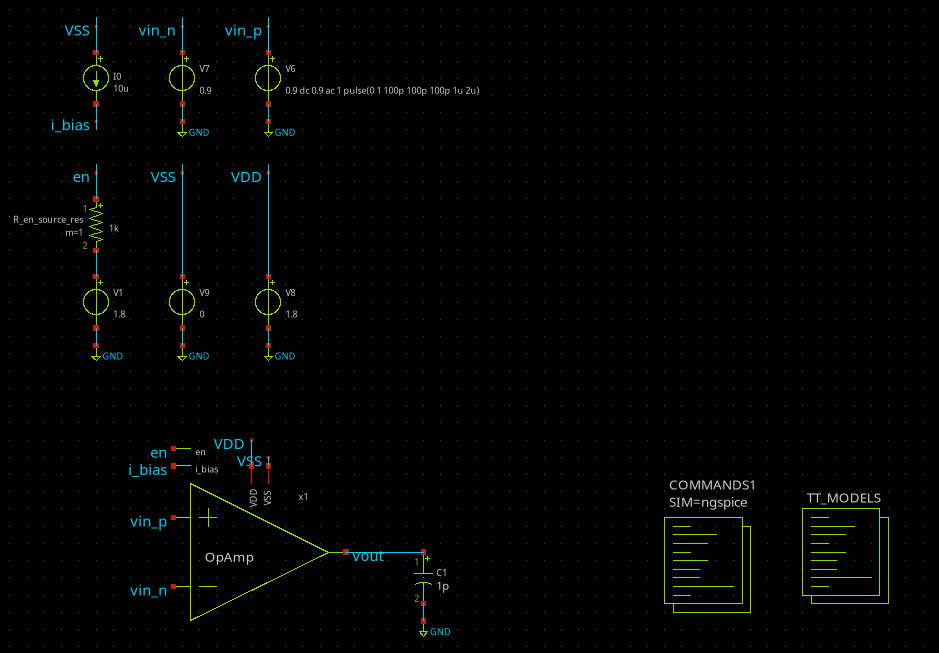

The performance parameters measured are as follows:

* **slew_rate**: Slew rate of the OpAmp as measured by the output voltage rise from 10% to 90% of the maximum power supply voltage.
* **power_average**: Average power consumption from the power supply over time.
* **aol_dc_db**: Open loop small signal gain measured at 10Hz.
* **bw3db**: Bandwidth of OpAmp small signal gain measured at 3dB below aol_dc_db.
* **ugbw**: Unity gain bandwidth is the frequency at 0dB small signal gain.
* **gain_margin**: Gain margin is defined as the magnitude of small signal gain at -180deg gain phase.
* **phase_margin**: Phase margin is defined as the difference between small signal gain phase and -180 phase at 0dB small signal gain magnitude.


An example plot of the small signal gain magnitude and phase is shown in the following diagrams for reference.

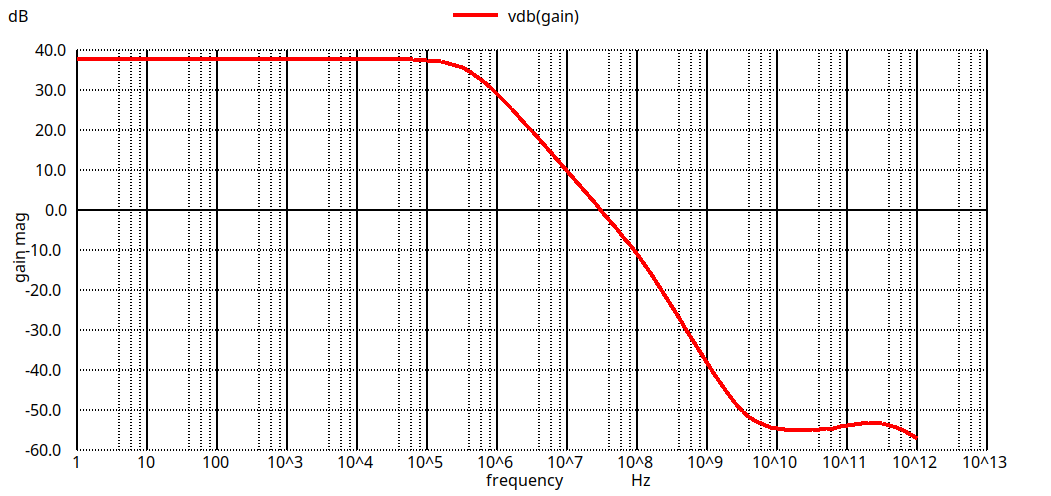

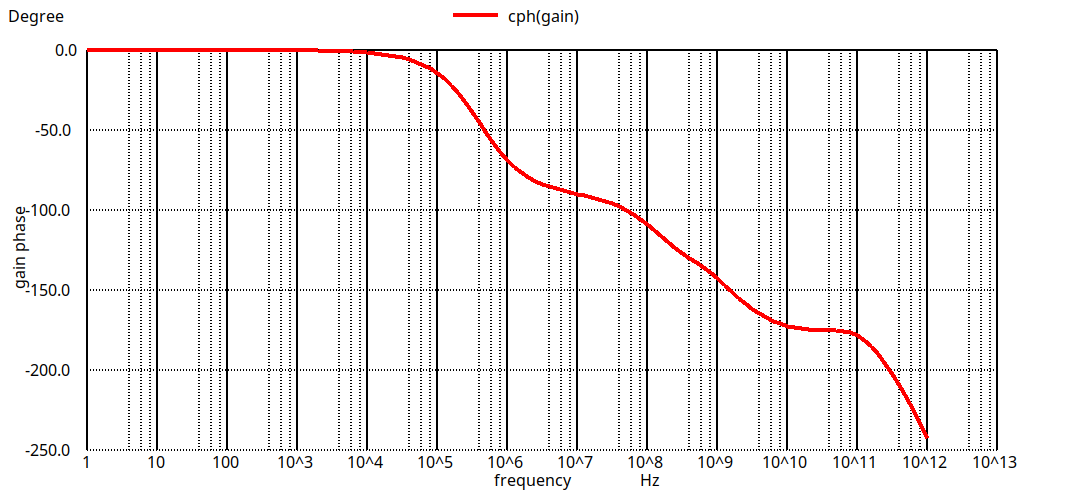

The next cell downloads the example SPICE netlist.

In [ ]:
# Download example SPICE netlist from github
spice_netlist_url = f"https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/ISSCC_2025_V1/netlist/test_analog.spice"
spice_netlist_filename = "test_netlist"
!wget {spice_netlist_url} -O {spice_netlist_filename}.spice
!mkdir generated_netlists

In [ ]:
# Open SPICE netlist
with open("{}.spice".format(spice_netlist_filename), "r") as netlist_file:
  netlist_contents = netlist_file.read()

  # Print file in terminal
  print(netlist_contents)

## Defect injection into SPICE netlists

In this section, the OpAmp testbench netlist is parsed and defects are injected into the netlists for all devices. It is assumed that that a single defect occurs in each circuit as per Section 3.2 of the IEEE P2427 Draft Standard [1].

The structure of FET devices in the netlist is defined as follows:
```
Fet structure (both n and p):
<inst_name> <drain> <gate> <source> <bulk> <cell_name>

Example:
XM1 vout Active_load_g VDD VDD sky130_fd_pr__pfet_01v8 ...

```

**Defect List**
* short between drain-source
* short between drain-gate
* short between source-gate
* open at drain
* open at source
* open at gate
* fast parameter variation
* slow parameter variation




Models of open and short defects are shown below. This is not an exhaustive list of all defect models. For example for high frequency circuits, series inductance can be modelled for short defects and parallel capacitance can be modelled for open defects. More information can be found in Section 3.2 of [1].

In this implementation, short defects are represented by a 1Ω resistor between the shorted terminals of the device. Open defects are represented by a 1 GΩ resistor at the drain and the source. For the open defect at the gate, a 100 TΩ resistor with biasing network between the drain and source is used which defines the DC voltage on the gate. This arrangement is required considering the fact that the CMOS gate input current is already very small even without a defect.


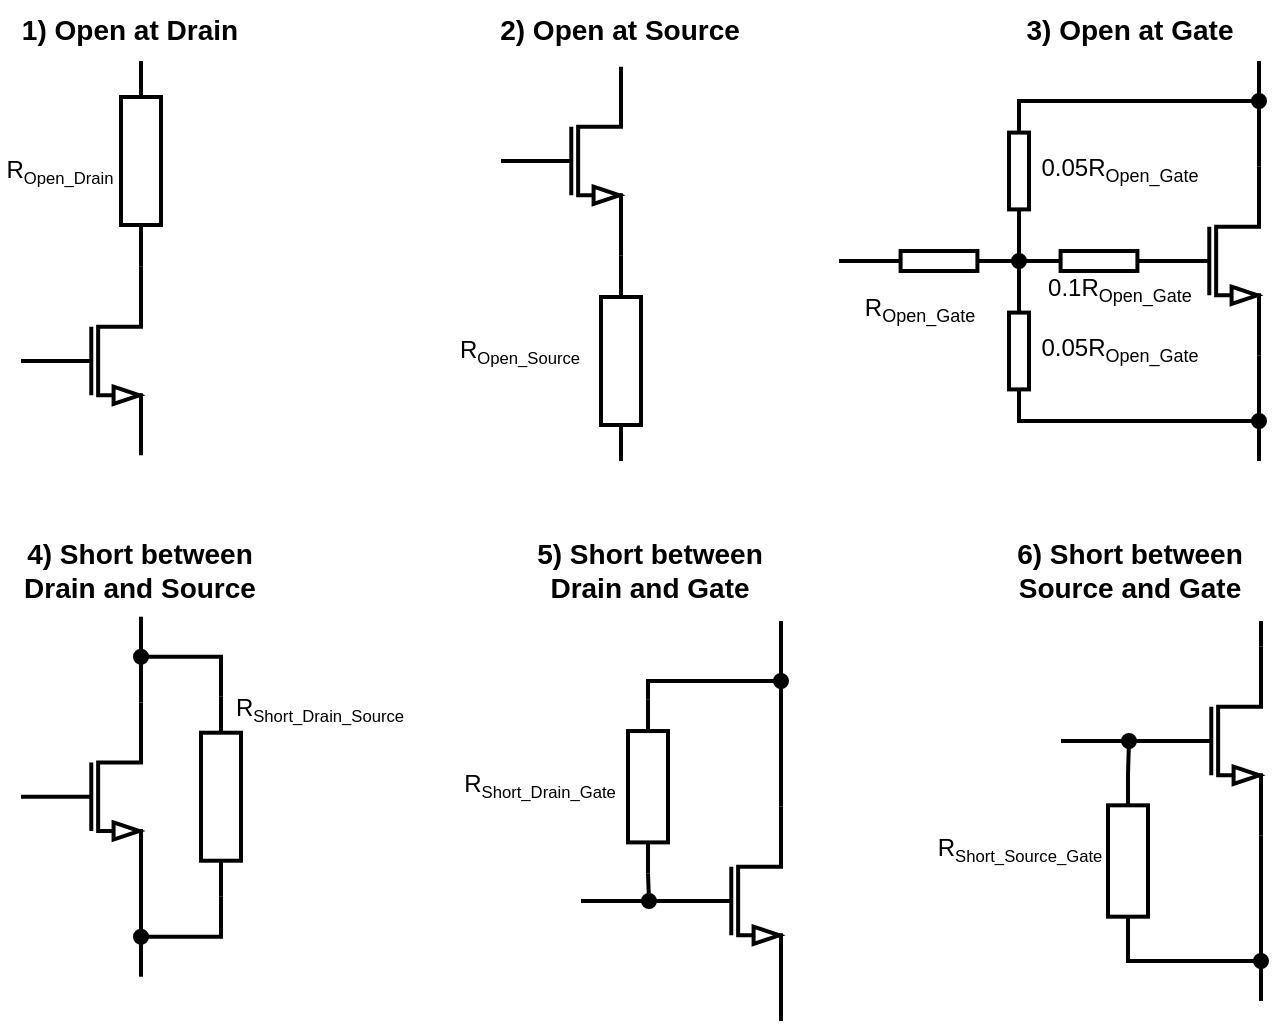



For fast and slow parameter variation defects, devices with parameter values (e.g. charge carrier mobility or threshold voltage) approximately 2-3 standard deviations above and below the specification limits are considered defective. This is because parametric changes within specification are usually taken into account during the design phase and are therefore not considered defects. Other implementations which include the temporal and stress-responses of transistors are not considered for simplicity.

For this implementation, modified transistors were created and added to the PDK. This modified transistor was created using the ff and ss corner transistors and by increasing the ``corner_factor`` from 1.0 to 1.5 to represent a transistor that operates outside of the acceptable performance parameters.


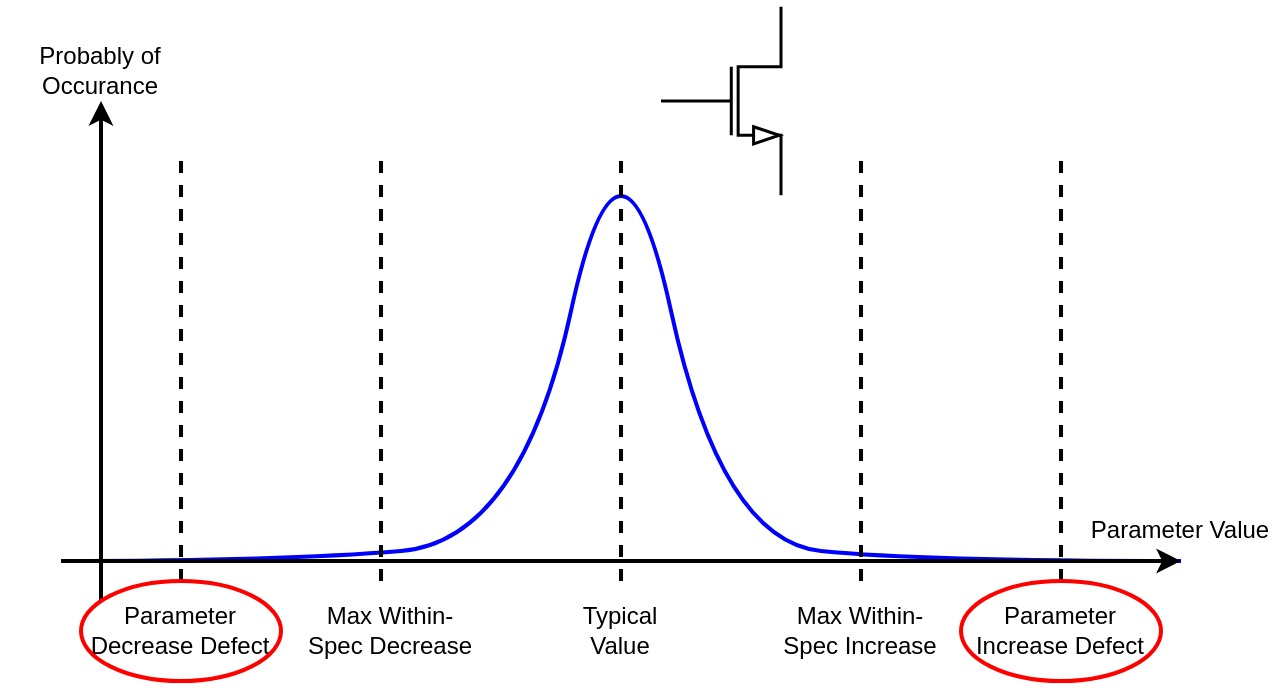

The implementation of defect injection is explained in the following cells.

The function ``get_fet_devices`` is created to parse the names and terminals of devices and return a list of devices.

In [ ]:
def get_fet_devices(netlist_contents):

  # Regular expression to extract FET devices (lines starting with XM)
  regex = r'(?P<inst_name>\w+\d+)\s(?P<drain>\w+)\s(?P<gate>\w+)\s(?P<source>\w+)\s(?P<bulk>\w+)\s(?P<cell_name>sky130_fd_pr__[np]fet_01v8)'
  fet_devices = re.findall(regex, netlist_contents)

  return fet_devices

# Dictionary for mapping transistor terminals to indices
defect_terminal_dict = {
  "Drain": 1,
  "Gate": 2,
  "Source": 3,
  "Bulk": 4,
}

``modify_nelist_open_defect``, ``modify_nelist_short_defect`` and ``modify_netlist_parameter_defect`` are used to inject open, short and parameter defects into a provided netlist. A jumper place holder is replaced with resistors in the open and short defect cases.

In [ ]:
def modify_nelist_open_defect(netlist, fet_device_terminals, defect_device, defect_terminal_name):

  # Get terminal number
  defect_terminal_num = defect_terminal_dict[defect_terminal_name]
  defect_terminal_netname = fet_device_terminals[defect_terminal_num]

  # Create 3 additional nets to replace original connected to device terminal
  defect_terminal_netname_replaced_1 = "{}1".format(defect_terminal_netname)
  defect_terminal_netname_replaced_2 = "{}2".format(defect_terminal_netname)
  defect_terminal_netname_replaced_3 = "{}3".format(defect_terminal_netname)

  fet_device_terminals_copy = fet_device_terminals.copy()
  # String of original device terminals
  original_device_terminals = " ".join(fet_device_terminals_copy)
  fet_device_terminals_copy[defect_terminal_num] = defect_terminal_netname_replaced_1
  # String of modified device terminals
  modified_device_terminals = " ".join(fet_device_terminals_copy)

  print("Open defect at", defect_terminal_name, fet_device_terminals_copy)

  # Replace device terminals
  modified_netlist = re.sub(original_device_terminals, modified_device_terminals, netlist)
  # Replace remaining occurances of net
  modified_netlist = re.sub(r"\b{}\b".format(defect_terminal_netname), defect_terminal_netname_replaced_2, modified_netlist)

  placeholder_jumper = "[\*] J1 [?]1 j1 [?]1 j2"

  if (defect_terminal_name == "Drain"):
    # Model open defect by adding a resistor
    modified_netlist = re.sub(placeholder_jumper, "R_drain_open {} {} 1G m=1"
      .format(defect_terminal_netname_replaced_1, defect_terminal_netname_replaced_2),
                              modified_netlist, count=1)
  elif (defect_terminal_name == "Source"):
    # Model open defect by adding a resistor
    modified_netlist= re.sub(placeholder_jumper, "R_source_open {} {} 1G m=1"
      .format(defect_terminal_netname_replaced_1,
              defect_terminal_netname_replaced_2),
                              modified_netlist, count=1)
  elif (defect_terminal_name == "Gate"):
    # Model open defect for gate by adding a resistor network
    modified_netlist = re.sub(placeholder_jumper, "R_gate1_drain_open {gate1} {drain} 0.5T m=1 \n \
      R_gate1_source_open {gate1} {source} 0.5T m=1 \n \
      R_gate1_gate_open {gate1} {gate} 1T m=1 \n \
      R_gate1_gate2_open {gate1} {gate2} 100T m=1"
      .format(gate=defect_terminal_netname_replaced_1,
              gate2=defect_terminal_netname_replaced_2,
              gate1=defect_terminal_netname_replaced_3,
              drain=fet_device_terminals_copy[1],
              source=fet_device_terminals_copy[3]),
                              modified_netlist, count=1)

  return modified_netlist

def modify_nelist_short_defect(netlist, fet_device_terminals, defect_device, defect_terminal_name_1, defect_terminal_name_2):

  print("Short defect at", defect_terminal_name_1, "-", defect_terminal_name_2, fet_device_terminals)

  # Get terminal number
  defect_terminal_num_1 = defect_terminal_dict[defect_terminal_name_1]
  defect_terminal_netname_1 = fet_device_terminals[defect_terminal_num_1]
  defect_terminal_num_2 = defect_terminal_dict[defect_terminal_name_2]
  defect_terminal_netname_2 = fet_device_terminals[defect_terminal_num_2]

  placeholder_jumper = "[\*] J1 [?]1 j1 [?]1 j2"

  if ((defect_terminal_name_1 == "Drain" and defect_terminal_name_2 == "Source") \
      or (defect_terminal_name_1 == "Source" and defect_terminal_name_2 == "Drain")):
    # Model open defect by adding a resistor
    modified_netlist = re.sub(placeholder_jumper, "R_drain_source_short {} {} 1 m=1"
      .format(defect_terminal_netname_1, defect_terminal_netname_2),
                              netlist, count=1)

  elif ((defect_terminal_name_1 == "Gate" and defect_terminal_name_2 == "Drain") \
        or (defect_terminal_name_1 == "Drain" and defect_terminal_name_2 == "Source")):
    # Model open defect by adding a resistor
    modified_netlist = re.sub(placeholder_jumper, "R_gate_drain_short {} {} 1 m=1"
      .format(defect_terminal_netname_1, defect_terminal_netname_2),
                              netlist, count=1)

  elif ((defect_terminal_name_1 == "Gate" and defect_terminal_name_2 == "Source") \
        or (defect_terminal_name_1 == "Source" and defect_terminal_name_2 == "Gate")):
    # Model open defect by adding a resistor
    modified_netlist = re.sub(placeholder_jumper, "R_gate_source_short {} {} 1 m=1"
      .format(defect_terminal_netname_1, defect_terminal_netname_2),
                              netlist, count=1)

  return modified_netlist

def modify_nelist_parameter_defect(netlist, fet_device_terminals, defect_device, speed):

  print(speed, "parameter defect at", fet_device_terminals[0], fet_device_terminals)

  placeholder_jumper = "[\*] J1 [?]1 j1 [?]1 j2"
  cellname_terminal_num = 5

  fet_device_terminals_copy = fet_device_terminals.copy()
  # String of original device terminals
  original_device_terminals = " ".join(fet_device_terminals_copy)

  if (speed == "fast"):
    if (fet_device_terminals_copy[cellname_terminal_num] == "sky130_fd_pr__pfet_01v8"):
      fet_device_terminals_copy[cellname_terminal_num] = "sky130_fd_pr__pfet_01v8_defect_fast"
    elif (fet_device_terminals_copy[cellname_terminal_num] == "sky130_fd_pr__nfet_01v8"):
      fet_device_terminals_copy[cellname_terminal_num] = "sky130_fd_pr__nfet_01v8_defect_fast"
  elif (speed == "slow"):
    if (fet_device_terminals_copy[cellname_terminal_num] == "sky130_fd_pr__pfet_01v8"):
      fet_device_terminals_copy[cellname_terminal_num] = "sky130_fd_pr__pfet_01v8_defect_slow"
    elif (fet_device_terminals_copy[cellname_terminal_num] == "sky130_fd_pr__nfet_01v8"):
      fet_device_terminals_copy[cellname_terminal_num] = "sky130_fd_pr__nfet_01v8_defect_slow"

  # String of modified device terminals
  modified_device_terminals = " ".join(fet_device_terminals_copy)

  # Replace device terminals
  modified_netlist = re.sub(original_device_terminals, modified_device_terminals, netlist)

  # Remove placeholder jumper device
  modified_netlist = re.sub(placeholder_jumper, "", modified_netlist)

  return modified_netlist

``generate_spice_netlists`` invokes ``modify_nelist_open_defect`` or ``modify_nelist_short_defect`` to generate a modified netlist which is then saved to a new file.

In [ ]:
def generate_spice_netlists(netlist, defect_type, fet_device_terminals, defect_device_num, defect_terminal_name_1, defect_terminal_name_2):

  if (defect_type == "Open"):
    modified_netlist_contents = modify_nelist_open_defect(
        netlist, fet_device_terminals, defect_device_num, defect_terminal_name_1)

  elif (defect_type == "Short"):
    modified_netlist_contents = modify_nelist_short_defect(
        netlist, fet_device_terminals, defect_device_num, defect_terminal_name_1,
        defect_terminal_name_2)

  elif (defect_type == "Parameter_Fast"):
    modified_netlist_contents = modify_nelist_parameter_defect(
        netlist, fet_device_terminals, defect_device_num, "fast")

  elif (defect_type == "Parameter_Slow"):
    modified_netlist_contents = modify_nelist_parameter_defect(
        netlist, fet_device_terminals, defect_device_num, "slow")

  modified_netlist_contents = re.sub("opamp_specs.txt", "opamp_specs_{}_{}_{}_{}_{}.txt"
      .format(defect_device_num,fet_device_terminals[0],
              defect_type,defect_terminal_name_1,defect_terminal_name_2),
                              modified_netlist_contents)

  # Open a file for writing modified netlist
  with open("./generated_netlists/{}_{}_{}_{}_{}_{}.spice"
    .format(spice_netlist_filename,defect_device_num,fet_device_terminals[0],
            defect_type,defect_terminal_name_1,defect_terminal_name_2), "w") as file:
      file.write(modified_netlist_contents)


Modified netlists are generated to model every type of defect for every transistor in the netlist.

In [ ]:
# Extract all fet devices from netlist
fet_devices = get_fet_devices(netlist_contents)

# Create netlists with defects injected
for defect_device_num in range(0,len(fet_devices)):
  fet_device_terminals = list(fet_devices[defect_device_num])
  generate_spice_netlists(netlist_contents, "Open", fet_device_terminals, defect_device_num, defect_terminal_name_1="Drain", defect_terminal_name_2=None)
  generate_spice_netlists(netlist_contents, "Open", fet_device_terminals, defect_device_num, defect_terminal_name_1="Source", defect_terminal_name_2=None)
  generate_spice_netlists(netlist_contents, "Open", fet_device_terminals, defect_device_num, defect_terminal_name_1="Gate", defect_terminal_name_2=None)
  generate_spice_netlists(netlist_contents, "Short", fet_device_terminals, defect_device_num, defect_terminal_name_1="Drain", defect_terminal_name_2="Source")
  generate_spice_netlists(netlist_contents, "Short", fet_device_terminals, defect_device_num, defect_terminal_name_1="Gate", defect_terminal_name_2="Drain")
  generate_spice_netlists(netlist_contents, "Short", fet_device_terminals, defect_device_num, defect_terminal_name_1="Gate", defect_terminal_name_2="Source")
  generate_spice_netlists(netlist_contents, "Parameter_Fast", fet_device_terminals, defect_device_num, defect_terminal_name_1=None, defect_terminal_name_2=None)
  generate_spice_netlists(netlist_contents, "Parameter_Slow", fet_device_terminals, defect_device_num, defect_terminal_name_1=None, defect_terminal_name_2=None)

The following cell is optional for downloading the generated_netlists.

In [ ]:
# # Download generated netlists
# !zip -r generated_netlists.zip /content/generated_netlists

# from google.colab import files
# files.download("/content/generated_netlists.zip")

## Batch running simulations with NGSpice

In this section, the modified netlists are run using the NGSpice simulator in batch mode.

In [ ]:
# Code to replace string in all spice files
# This was created to replace .lib path for netlists created locally
def replace_string_in_spice_files(folder_path, original_pdk_path, final_pdk_path):

  # Iterate over files in directory
  for spice_file_name in os.listdir(folder_path):
    if spice_file_name.endswith(".spice"):

      # Read files
      with open(os.path.join(folder_path, spice_file_name), 'r') as spice_file:
        netlist = spice_file.read()

      modified_netlist = re.sub(original_pdk_path, final_pdk_path, netlist)

      # Write modified files
      with open(os.path.join(folder_path, spice_file_name), 'w') as spice_file:
        spice_file.write(modified_netlist)

replace_string_in_spice_files("/content/generated_netlists", "/usr/local/share/pdk/sky130B/", "/content/conda-env/share/pdk/sky130A/") #"/foss/pdks/sky130A/"

In [ ]:
# Download batch run shell file from github
ngspice_batchrun_file_url = f"https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Jupyter_Notebooks/ngspice_batchrun.sh"
ngspice_batchrun_file = "ngspice_batchrun.sh"
!wget {ngspice_batchrun_file_url} -O {ngspice_batchrun_file}

specs_dir = "./specs/"
!mkdir {specs_dir}

Run NGSpice batchrun script. This might take a few minutes since multiple netlists are simulated sequentially. After the simulation is completed for each netlist, a summary of performance parameters is created in the ``/specs`` folder.

In [ ]:
!bash /content/ngspice_batchrun.sh

## Automated testing of performance parameter files
In this section, the testbench performance parameters for circuits with all possible defects are compared with the acceptable ranges in ``specs_range.txt``.

In [ ]:
# Download specs range file from github
specs_range_file_url = f"https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Jupyter_Notebooks/opamp_specs_range.txt"
specs_range_file = "specs_range.txt"
!wget {specs_range_file_url} -O {specs_range_file}

The specification files consists of minimum and maximum values for the performance parameters in separate lines.

In [ ]:
# Open specs_range.txt file
with open(specs_range_file, "r") as specs_range_file_content:
  # Print file in terminal
  print(specs_range_file_content.read())

``register_ranges`` parses a file with performance parameter ranges and creates a dictionary containting the ranges.

``test_specs_file`` uses the performance parameter ranges to test the simulated performance parameters for all defects and returns a dictionary with results.

In [ ]:
def register_ranges(path_file_range):

  range_dict = {}

  # Opens specs_range file and places max and min into a dictionary
  with open(path_file_range, "r") as file:
    for line in file:
      # Regex to find numbers after '='
      match_number_min = re.search(r"=\s*(-?\d+(\.\d+)?([eE][+-]?\d+)?)", line)
      match_number_max = re.search(r":\s*(-?\d+(\.\d+)?([eE][+-]?\d+)?)", line)

      match_spec_property = re.search(r"([^\s=]+)\s*=", line)

      if match_spec_property:
          spec_property = match_spec_property.group(1)

      if match_number_max:
          spec_value_max_scientific = match_number_max.group(1)  # Extract the matched number (its common name to hold reg expressions)
          spec_value_max = float(spec_value_max_scientific)

      if match_number_min:
          spec_value_min_scientific = match_number_min.group(1)  # Extract the matched number (its common name to hold reg expressions)
          spec_value_min = float(spec_value_min_scientific)

      range_dict[f"{spec_property}"] = [spec_value_min, spec_value_max]

    return range_dict

In [ ]:
def test_specs_file(path_file, range_dict):

  results_dict = {}
  results_dict["path_file"] = path_file

  overall_result = 1

  with open(path_file, "r") as file:
    for line in file:

      # Regex to find numbers after '='
      match_number = re.search(r"=\s*(-?\d\.?\d+[Ee][+\-]\d\d?)", line)
      match_spec_property = re.search(r"([^\s=]+)\s*=", line)

      if match_spec_property:
        spec_property = match_spec_property.group(1)

      if match_number:
        spec_value_scientific = match_number.group(1)  # Extract the matched number (its common name to hold reg expressions)
        spec_value = float(spec_value_scientific)

      if range_dict[spec_property][0] <= spec_value <= range_dict[spec_property][1]:
        results_dict[spec_property] = 1

      else:
        results_dict[spec_property] = 0
        overall_result = 0

  results_dict["overall_result"] = overall_result

  return results_dict

The next cell runs the automated tests on all generated performance parameter files.

In [ ]:
range_dict = register_ranges(path_file_range=specs_range_file)
results_dict_list = []

# Iterate over performance parameter files in directory
for filename in os.listdir(specs_dir):
    results_dict = test_specs_file(os.path.join(specs_dir, filename), range_dict)
    results_dict_list.append(results_dict)

results_df = pd.DataFrame(results_dict_list)
results_df.to_csv("results_summary.csv")

A summary of the test results for all defect circuits is presented. The ``results_summary.csv`` file can also be downloaded for viewing in a local spreadsheet viewer.

In [ ]:
results_df

As can be seen from the results summary, defect netlists that have "1" for the ``overall_result`` column have not failed in the testing regime despite the presence of a defect. These defects are not covered by the tests and should be examined more closely to determine if more tests should be added to improve test coverage.

## Data Visualisation

A script with TCL commands is generated by filtering the test results that passed. This TCL script is used to programmatically control XSchem to highlight the instance involved in the test and print a png image. This is to help visualise the defects that cannot be detected.

In [ ]:
filtered_data = results_df[results_df['overall_result'] == 1]

# Generate TCL commands with unique filenames
with open('xschem_commands.tcl', 'w') as file:
    # file.write(f'xschem OpAmp.sch\n')
    for index, row in filtered_data.iterrows():
        # Extract the instance name from path_file (e.g., "XM10")
        path_parts = row['path_file'].split('_')
        instance_name = path_parts[3][1:]  # e.g., "M10"
        additional_info = '_'.join(path_parts[4:]).replace('.txt', '')  # e.g., "Open_Drain_None"

        # Create a unique filename using the index
        unique_filename = f"{instance_name.lower()}_{additional_info.lower()}_{index}.png"

        # Write TCL commands
        file.write(f'xschem hilight_instname {instance_name}\n')
        file.write(f'xschem print png {unique_filename} 0 0 -800 -650 650 200\n') # export the area where the circuit is
        file.write(f'xschem unhilight_all\n')

print("TCL commands have been written to 'xschem_commands.tcl'")

In [ ]:
# Import op amp schematic file from github
!wget https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/ISSCC_2025_V1/xschem/Benchmark_Circuits/OpAmp/OpAmp.sch -O OpAmp_Schematic.sch


In [ ]:
# Code to replace string in all spice files
# This was created to replace .lib path for netlists created locally
def replace_string_in_sch_files(folder_path, original_pdk_path, final_pdk_path):

  # Iterate over files in directory
  for spice_file_name in os.listdir(folder_path):
    if spice_file_name.endswith(".sch"):

      # Read files
      with open(os.path.join(folder_path, spice_file_name), 'r') as spice_file:
        netlist = spice_file.read()

      modified_netlist = re.sub(original_pdk_path, final_pdk_path, netlist)

      # Write modified files
      with open(os.path.join(folder_path, spice_file_name), 'w') as spice_file:
        spice_file.write(modified_netlist)

replace_string_in_sch_files("/content", "/usr/local/share/pdk/sky130A/", "/content/conda-env/share/pdk/sky130A/") #"/foss/pdks/sky130A/"

There were issues implementing the export of images from Xschem within the Jupyter Notebook environment. As a result, images were generated locally and imported.

In [ ]:
# Issue trying to generate png images in Jupyter Notebook, tcl commands not reacting, could be due to absence of gui
# !xschem OpAmp_Schematic.sch --script xschem_commands.tcl -l test.log -b -q

In [ ]:
# Import images that are generated in our local environment using the script generated into the images folder
!mkdir images
!wget https://github.com/TimothyJNewman/open-source-chip-design-v1/raw/refs/heads/main/Automated_Image_Export/screenshots_2.tar.gz -O images/defect_images.tar.gz

In [ ]:
!rm -rf images/*.png
!cd images && tar -xzvf /content/images/defect_images.tar.gz

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_directory = "/content/images"

def generate_label(filename):
    parts = filename.split('_')  # Split the filename by '_'
    instance = parts[0].upper()  # E.g., "M10"
    defect_type_1 = '_'.join(parts[1:2])
    defect_type_2 = '_'.join(parts[2:3])
    defect_type_3 = '_'.join(parts[3:4])
    return f"Defect for {defect_type_1} between {defect_type_2} and {defect_type_3} of {instance} not detected"

for file in os.listdir(image_directory):
    if file.endswith(".png"):  # Check if the file is a PNG image
        filepath = os.path.join(image_directory, file)

        # Open the image
        img = Image.open(filepath)

        # Generate the label
        label = generate_label(file)

        # Display the image with the label
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(label, fontsize=12, wrap=True)
        plt.show()

In [ ]:
total_tests = len(results_df)
defect_coverage_percentage = (len(results_df[results_df['overall_result'] == 0]) / total_tests) * 100

print("Defect coverage percentage = ", defect_coverage_percentage, "%")

## Discussion

### Defect Coverage

It can be found from the procedure that 30.7% of defects are not detected by the tests.

Many of the defects not detected by the tests are for the digital circuits and enable switches. To detect some of these cases, it might be advisable to add more tests such as average off-state power consumption which will catch cases where the enable devices are bypassed for instance.

In certain cases such for the current mirror input device M2, there is an intentional short between the drain and gate. As such, a drain-gate short defect would not affect performance. This defect can be waivered.

It was also noticed that some tests yield very similar outcomes such as unity gain-bandwidth product and gain margin. Due to the high correlation between these tests, one of them can be eliminated to save on testing time and costs.

### Scalability
In the OpAmp example, there are 11 transistors which results in a defect universe of 88. However, in larger circuits, the number of devices and therefore number of simulations will increase until it is no longer feasible to run. At that point, a selection of defects can instead be tested through either simple random or likelyhood-weighted random sampling [1] to provide an estimated coverage.

## Conclusion


In conclusion, a prototype implementation of the IEEE P2427 analog IC defect coverage standard was developed with an open source design flow. An example circuit was used to demontrate this implementation and the defect universe and coverage was generated, simulated and analysed.

Further improvements to this project could be to:

* Test the framework on more circuits
* Implement randomised tested for larger circuit
netlists  
* Improve the visualisation of defective netlists to better reflect the location and type of defect
* Create automated suggestions of tests to include or remove from the lists of tests